# Playing with sample kHz QPO dataset

In [1]:
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
lc_fits = Table.read('./toy_kHz_lightcurve.fits')
meta = lc_fits.meta
print(lc_fits.info())
print(meta)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
lc_fits

<Table length=32768>
name  dtype   shape 
---- ------- -------
 REF float64   (20,)
  CI float64 (5, 20)
None
OrderedDict([('N_BINS', 32768), ('DT', 0.00048828125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Dropbox/Research/kHz_QPO_phase_res/toy_chbinfile.txt'), ('N_SEG', 20), ('NSECONDS', 16)])


REF [20],"CI [5,20]"
float64,float64
2048.0 .. 0.0,0.0 .. 0.0
2048.0 .. 4096.0,0.0 .. 0.0
0.0 .. 0.0,0.0 .. 0.0
6144.0 .. 0.0,0.0 .. 0.0
2048.0 .. 4096.0,0.0 .. 0.0
4096.0 .. 0.0,0.0 .. 0.0
6144.0 .. 4096.0,0.0 .. 0.0
2048.0 .. 2048.0,0.0 .. 0.0
0.0 .. 2048.0,0.0 .. 0.0


In [3]:
# multiply dt to get counts
ref = np.array(lc_fits['REF'] * dt)
ci = np.array(lc_fits['CI'] * dt)
print(ref.shape, ci.shape)

(32768, 20) (32768, 5, 20)


## What I learned about the dataset
Given dataset has:-
-  2 sets of lightcurves (REF and CI)
-  5 channels of interest
-  32768 bins of photon energy
-  20 sequential segments
-  'count rate' as unit

In [4]:
print(ref)
print(ref[0])

[[1. 0. 1. ... 2. 2. 0.]
 [1. 3. 2. ... 0. 1. 2.]
 [0. 2. 2. ... 1. 1. 0.]
 ...
 [0. 1. 0. ... 1. 2. 1.]
 [0. 0. 3. ... 0. 0. 2.]
 [1. 1. 2. ... 2. 0. 1.]]
[1. 0. 1. 1. 0. 3. 0. 0. 1. 1. 1. 1. 2. 1. 0. 0. 3. 2. 2. 0.]


(32768, 20) (655360,)
655360 655360


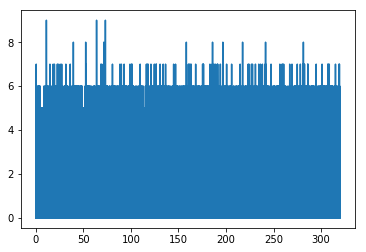

In [31]:
start = 0
stop = 20
a = np.array([])
for i in range(start, stop):
    a = np.concatenate((a, (np.array(ref[:, i:i+1]).T)[0]))

num_segments = stop-start
counts = a
print(ref.shape, counts.shape)
times = np.arange(0,n_seconds*num_segments, dt)
print(len(times), len(counts))
# print(times)
lc = Lightcurve(times, counts, dt=dt)
lc.plot()


Old dt:  0.00048828125
New dt:  0.0048828125


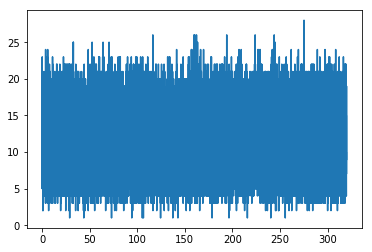

In [32]:
lc_rebin = lc.rebin(dt*10)
print("Old dt: ", lc.dt)
print("New dt: ", lc_rebin.dt)
lc_rebin.plot()

## Powerspectrum and AveragedPowerspectrum

A Powerspectrum object has the following properties :
    -  freq : Numpy array of mid-bin frequencies that the Fourier transform samples.
    -  power : Numpy array of the power spectrum.
    -  df : The frequency resolution.
    -  m : The number of power spectra averaged together. For a Powerspectrum of a single segment, m=1.
    -  n : The number of data points (time bins) in one segment of the light curve.
    -  nphots1 : The total number of photons in the light curve.


26.537528840953623


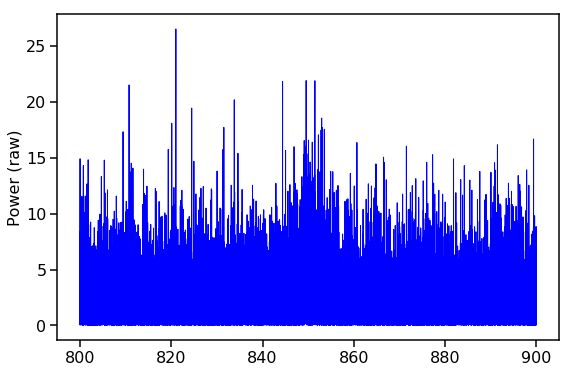

In [33]:
ps = Powerspectrum(lc, norm='leahy')

# print(len(ps.freq))
# print(ps.freq)
# print(ps.power)
# print(ps.df)
# print(ps.m)
# print(ps.n)
# print(ps.nphots1)

print(max(ps.power))

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(ps.freq[int(800/1024*len(ps.freq)):int(900/1024*len(ps.freq))], ps.power[int(800/1024*len(ps.freq)):int(900/1024*len(ps.freq))], lw=1, color='blue')
ax1.set_ylabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

0.003125
0.0625


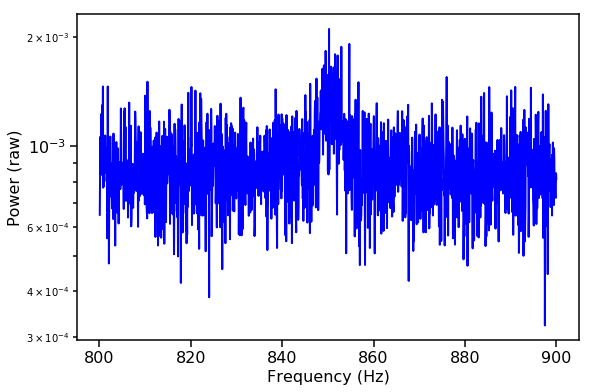

In [37]:
segment_size = n_seconds
avg_ps = AveragedPowerspectrum(lc, segment_size=segment_size)
print(ps.df)
print(avg_ps.df)

range_start = 800 * segment_size
range_stop = 900 * segment_size

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(avg_ps.freq[range_start:range_stop], avg_ps.power[range_start:range_stop], lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()